# For Colab

In [ ]:
!wget https://github.com/Chiffaa/Glacier-lakes-detection-using-multi-resolution-input-channels/archive/refs/heads/main.zip

!unzip /content/main.zip

In [ ]:
! pip install rasterio

In [ ]:
! pip install wandb

In [ ]:
# import kaggle.json file before
! mkdir  ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Import

In [1]:
from data_loader import LakesDataset, get_loaders
from architecture import UNet, padding
from train import train, BATCH_SIZE, DEVICE, LEARNING_RATE
from utils import check_accuracy
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = 32

# If the patch_size is given, and the data was still not preprocessed to this size, it is creating a new folder data_patch_size and uses it
train_dataset =LakesDataset(train=True, val=0.2, data_path = '../', patch_size = 256)
val_dataset = LakesDataset(train=False, val=0.2, data_path = '../', patch_size=256)
test_dataset =LakesDataset(train=False, data_path = '../', patch_size = 256)

In [3]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1370
343
429


In [2]:
loaders = get_loaders(patch_size=256, data_path='../', val_split=0.2, batch_size=BATCH_SIZE, shuffle=True)

examples_train = iter(loaders['train_loader'])
samples_train, labels_train = next(examples_train)
print(samples_train.shape, labels_train.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])


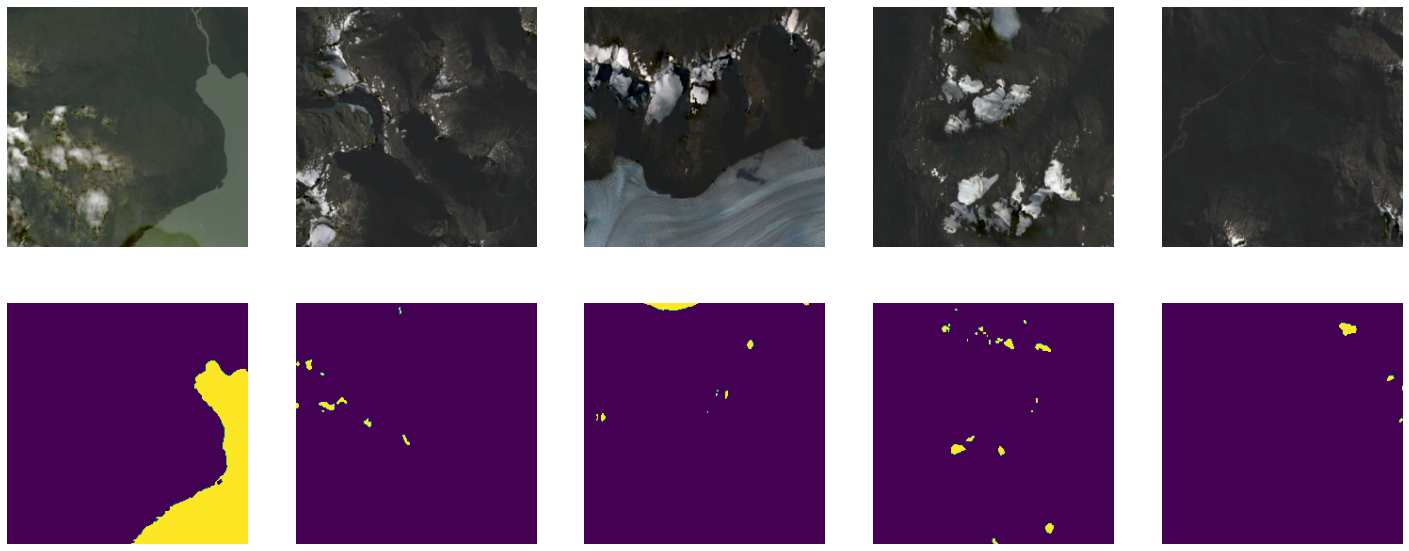

In [10]:
plt.figure(figsize=(25, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples_train[i+3].permute(1,2,0))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(labels_train[i+3].permute(1,2,0))
    plt.axis("off")

# Train

In [3]:
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = 'IoU'
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [4]:
train(model, loaders, loss_fn, optimizer, epochs=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elena-golimblevskaya. Use `wandb login --relogin` to force relogin


  7%|▋         | 3/43 [05:21<1:11:29, 107.24s/it, loss=1.11]


batch,▁▅█
epoch,▁▁▁
loss,█▄▁
batch,2
epoch,0
loss,1.11136


KeyboardInterrupt: 

# Statistics

In [2]:
# Calculating white and black pixels in label
def pixel_count(label):
    return np.array([(label.sum()).item(), (label.sum()/label.numel()).item()])

In [6]:
def stats(patch_size=None):
    train_dataset =LakesDataset(train=True, data_path = '../', patch_size = patch_size)
    test_dataset =LakesDataset(train=False, data_path = '../', patch_size = patch_size)
    pixels_num = []
    for i in range(len(train_dataset)):
        pixels_num.append(pixel_count(train_dataset.__getitem__(i)[1]))

    for i in range(len(test_dataset)):
        pixels_num.append(pixel_count(test_dataset.__getitem__(i)[1]))

    return np.array(pixels_num).T


In [7]:
pixels_256 = stats(patch_size=256)
pixels_512 = stats(patch_size=512)
pixels_1024 = stats(patch_size=1024)
pixels = stats()

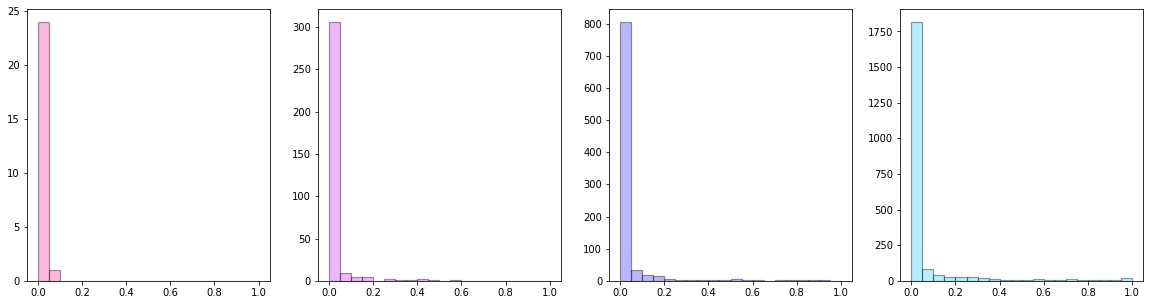

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
data = [pixels_256[1], pixels_512[1], pixels_1024[1], pixels[1]][::-1]
colors = ['#ff4da6', '#d84dff', '#524dff', '#4dd8ff']

for i in range(4):
    ax[i].hist(data[i], bins=20, range=(0.0, 1.0), color=colors[i], edgecolor='black', linewidth=1.2, alpha=0.4)

plt.show()

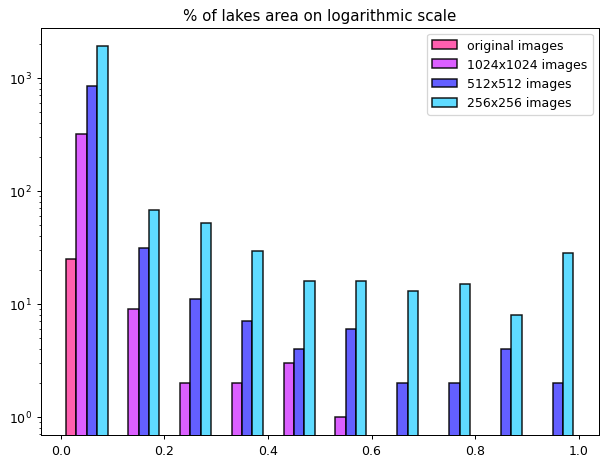

In [59]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=90)
labels = ['original images', '1024x1024 images', '512x512 images', '256x256 images']
plt.hist(data, color=colors, edgecolor='black', linewidth=1.2, alpha=0.9)
plt.yscale('log')
plt.legend(labels)
plt.title("% of lakes area on logarithmic scale")
plt.show()